# Type-token ratio in Universal Dependencies treebanks (1.2 updated)

For measuring the degree of synthesis in a language, the type-token ratio has been used as a sort of latent variable. The assumption is that languages with a high degree of synthesis will have a higher type/token ratio.

Here, we calculate the ratio for all languages available in the UD treebanks (1.1).

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)
#mpl.rcParams.update({"font.family": "Bookman"})

treebank_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../tools/')
import udtree, lang_utils

import pandas as pd

from os import listdir
from os.path import join
from collections import defaultdict

file_format = "conllu"
train_type = "train"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "ttr"
treebanks = lang_utils.get_ud_paths(gold_output_base, type_=train_type, format_=file_format, coarse=False)

In [2]:
def calculate_ttr(trees):
    words = defaultdict(int)
    for tree in trees:
        for word in tree.words:
            words[word] += 1
    
    return sum(words.values()) / len(words)

In [5]:
token_type_ratio = {}
for language, treebank in treebanks.items():
    token_type_ratio[language] = calculate_ttr(udtree.from_files(treebank))

ttr = pd.Series(token_type_ratio).sort_values()

## TTR results on training set

In [4]:
ttr

Polish                  3.075585
Finnish                 3.310433
Basque                  3.796379
Slovenian               3.825699
Greek                   4.595545
Croatian                4.651343
Bulgarian               4.966643
Danish                  5.069451
Swedish                 5.161877
Old_Church_Slavonic     5.212935
Gothic                  5.757209
Dutch                   6.768994
Portuguese              7.092235
Arabic                  7.245380
Norwegian               8.139665
Hebrew                  8.167822
Spanish                 8.275328
Persian                 9.115697
Italian                 9.171093
Czech                   9.360645
English                10.410971
Hindi                  16.558089
dtype: float64

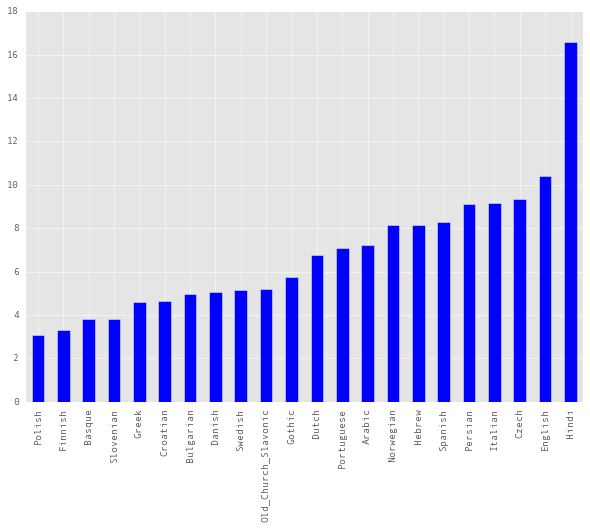

In [5]:
ttr.plot(kind='bar')

The TTR order of the UD treebank languages seem to somewhat follow the intuition, where English as a highly isolated language is ranked highest, while Hungarian Finnish, and Basque are at the bottom. One clear outlier is Czech, which as a highly fusional language should have a much lower ratio. After investigation I realized that since the Czech training data is an order of magnitude larger than all other data, the type/token ratio naturally becomes much lower. This has been verified by others as well [[1]](http://link.springer.com/article/10.1007%2Fs11185-015-9151-8#).

# Standardised TTR

While [1] suggests a new measurement, zTTR, it seems a bit more difficult to implement so I'll just settle with Standardized TTR (sTTR) for now, which is the average TTR over chunked input of 1000 words.

In [2]:
def calculate_chunked_ttr(trees):
    max_chunk_size = 1000
    chunks = [defaultdict(int)]
    chunk_size = 0
    for tree in trees:
        for token in tree.tokens:
            if chunk_size > max_chunk_size:
                chunks.append(defaultdict(int))
                chunk_size = 0
            chunks[-1][token] += 1
            chunk_size += 1
    
    ttrs = map(lambda tokens: len(tokens) / sum(tokens.values()), chunks)
    return ttrs

token_type_ratio = {}
for language, treebank in treebanks.items():
    series = pd.Series(calculate_chunked_ttr(udtree.from_files(treebank)))
    token_type_ratio[language] = pd.Series({'mean': series.mean(), 'std_deviation': series.std()})


In [3]:
ttr = pd.concat(token_type_ratio, axis=1).transpose().sort_values('mean')
ttr.to_csv('../data/standard_ttr.1.2.csv')
ttr

,mean,std_deviation
Hindi,0.422420,0.021695
English,0.439059,0.036758
Persian,0.442695,0.045416
Norwegian,0.457679,0.037570
Portuguese,0.471063,0.017455
Italian,0.472097,0.052337
Swedish,0.479409,0.032571
Gothic,0.483249,0.051700
Arabic,0.517218,0.027903
Old_Church_Slavonic,0.521597,0.044025


In [4]:
content_dist = pd.Series.from_csv('../data/maltdefault.content_dist.csv')
content_sttr = pd.concat([ttr['mean'], content_dist], axis=1)
renamed = content_sttr.rename(index={'Old_Church_Slavonic': 'O.C. Slavonic'}, columns={'mean': 'STTR', 0: "Content deprel ratio"})
renamed.sort_values('STTR').plot(kind='barh', figsize=(3.5, 3), fontsize=6)
plt.legend(fontsize=3, loc=4)
plt.tight_layout()
plt.savefig('../paper/figures/standard_ttr.pgf')
renamed.corr()

OSError: File b'../data/maltdefault.content_dist.csv' does not exist

In [ ]:
two_three = {"English", "Hindi", }
four_five = {"Greek", "Hebrew", "Persian", "Spanish", }
six_seven = {"Arabic"}